# Running FEISTY with forcing from CESM

Kristen generated the forcing files, I believe with `/glade/u/home/kristenk/fish-offline/notebooks/proc-cesm-dple-fields.ipynb`.
This notebook doesn't really need to be a notebook, I'm hoping it can be converted to a script instead.
All the parameter settings are handled in the first (non-`import`) cell, where we read in `feisty-config.FOSI_CESM.yml`.
This was run on a casper compute node with 15 GB of memory.

## Imports

In [1]:
import os

import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client
from dask_jobqueue import PBSCluster

import feisty

## Configure run

The FEISTY command `config_and_run_from_yaml()` needs a dictionary pointing to forcing streams and initial conditions.
We provide a few `YAML` files containing acceptable configurations.
There are also several parameters controlling how the run is set up.

In [2]:
# Read settings from YAML
feisty_config_file = 'feisty-config.FOSI_CESM.yml'
with open(feisty_config_file) as f:
    feisty_config = yaml.safe_load(f)

## Set up Dask cluster

Since the data in `ds` is chunked in `X`, we use a `dask` cluster to configure the parallelization

In [3]:
mem = 12  # GB
dask.config.set({'distributed.dashboard.link': 'proxy/{port}/status'})
# dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
# dask.config.set({"distributed.comm.timeouts.connect": "180s"})
cluster = PBSCluster(
    memory=f'{mem} GB',
    processes=1,
    cores=1,
    queue='casper',
    walltime='1:00:00',
    resource_spec=f'select=1:ncpus=1:mem={mem}GB',
    log_directory='./dask-logs',
)

cluster.scale(feisty_config['num_workers'])
client = Client(cluster)
client

/glade/work/mlevy/miniconda3/envs/dev-feisty/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37843 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: proxy/37843/status,
Dashboard: proxy/37843/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.39:38371,Workers: 0
Dashboard: proxy/37843/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Run the model

In [4]:
%%time
ds_out = feisty.config_and_run_from_yaml(feisty_config)
da_out = ds_out["biomass"]

Starting template generation at 13:15:10
CPU times: user 4.28 s, sys: 598 ms, total: 4.88 s
Wall time: 1min 34s


### Plotting

Make a plot of `biomass` over time at a specified column

In [5]:
# Select a column to look at

### FOSI simulations
X = 55000  # looks good compared to matlab (not plotted in this notebook)
# X = 15633  # large error in small classes
# X = 11677  # large error in medium classes
# X = 76989  # large error in benthic

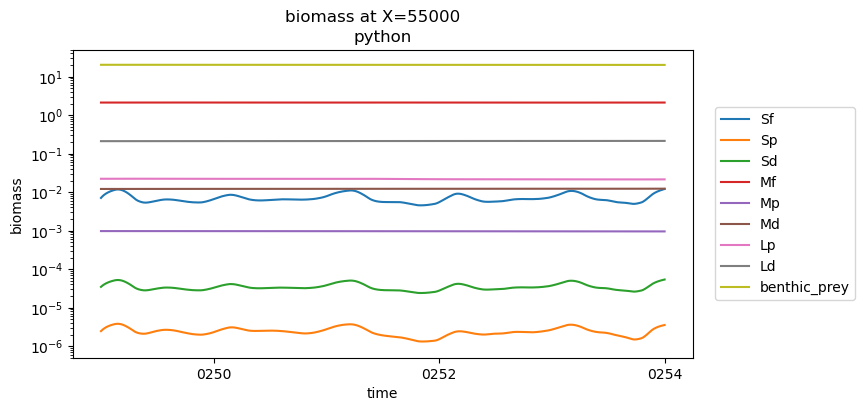

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for group in ds_out.group.data:
    da_out.sel(group=group).isel(X=X).plot(ax=ax)
ax.set_ylim([5e-7, 50])
ax.set_yscale("log")
ax.set_title("python")
plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
fig.suptitle(f"biomass at X={X}");